# G04. 이미지 어디까지 우려볼까?

## 들어가며

![GC-2-P-1.max-800x600.jpg](img/GC-2-P-1.max-800x600.jpg)

이번 시간에는 augmentation 기법을 적용해 ResNet-50을 학습시켜 보도록 하겠습니다. 텐서플로우의 랜덤 augmentation API를 사용해 보고, 최신 augmentation 기법을 익힌 뒤, 훈련 데이터셋의 augmentation 적용 여부에 따라 모델의 성능이 달라지는지 비교해 보겠습니다.

## 실습목표
***
Augmentation을 모델 학습에 적용하기  
Augmentation의 적용을 통한 학습 효과 확인하기  
최신 data augmentation 기법 구현 및 활용하기  

## 학습 내용
***
Augmentation 적용 (1) 데이터 불러오기  
Augmentation 적용 (2) Augmentation 적용하기  
Augmentation 적용 (3) 비교 실험하기   
심화 기법 (1) Cutmix Augmentation  
심화 기법 (2) Mixup Augmentation  
프로젝트: CutMix 또는 Mixup 비교실험하기  


# libary import

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Augmentation 데이터셋 준비 
---
![96831035-4bc81680-1477-11eb-9132-b95848c002c3.png](img/96831035-4bc81680-1477-11eb-9132-b95848c002c3.png)


## CutMix란?
---
- [논문링크](https://arxiv.org/pdf/1905.04899.pdf)
- 간단하게 데이터를 자르고 섞는다.
- 위에 사진처럼 사진데이터를 잘라서 섞고 라벨에 대한 값 또한 전체사진에 차지하는 비율만큼 라벨을 새로 만들어 준다.

## 데이터셋 불러오기

In [3]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [4]:
ds_info.features["label"].names[:10]

['n02085620-chihuahua',
 'n02085782-japanese_spaniel',
 'n02085936-maltese_dog',
 'n02086079-pekinese',
 'n02086240-shih-tzu',
 'n02086646-blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-rhodesian_ridgeback',
 'n02088094-afghan_hound']

In [5]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


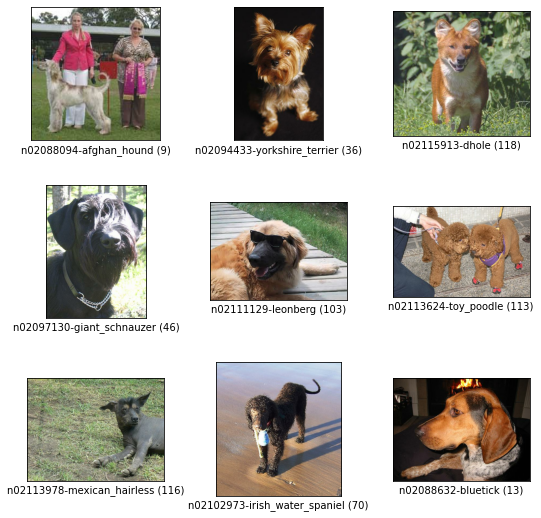

In [6]:
fig = tfds.show_examples(ds_info, ds_train)

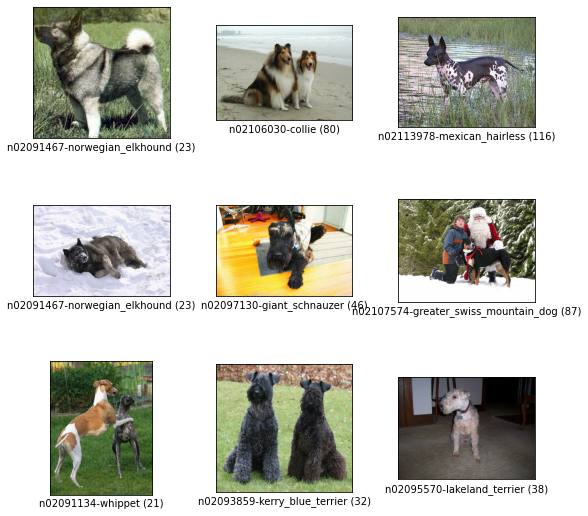

In [7]:
fig = tfds.show_examples(ds_test, ds_info)

In [8]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [9]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

## 이미지 섞기

#### 두개의 이미지 선택

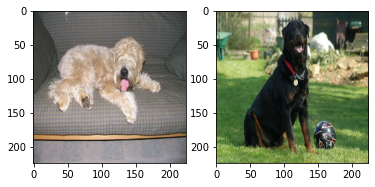

In [11]:
# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

#### a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수

In [12]:
def get_clip_box(image_a, image_b, img_size=224):
    # get center of box
    x = tf.cast( tf.random.uniform([],0, img_size),tf.int32)
    y = tf.cast( tf.random.uniform([],0, img_size),tf.int32)

    # get width of box
    _prob = tf.random.uniform([],0,1)
    width = tf.cast(img_size * tf.math.sqrt(1-_prob),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-width//2)
    yb = tf.math.minimum(img_size, y+width//2)
    xb = tf.math.minimum(img_size, x+width//2)
    
    return xa, ya, xb, yb

In [13]:
xa, ya, xb, yb = get_clip_box(image_a, image_b)
print(xa, ya, xb, yb)

tf.Tensor(13, shape=(), dtype=int32) tf.Tensor(43, shape=(), dtype=int32) tf.Tensor(125, shape=(), dtype=int32) tf.Tensor(155, shape=(), dtype=int32)


#### 위에서 추출한 bouding box의 점을 가지고 이미지를 섞는다

In [14]:
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb, img_size=224):
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:img_size,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:img_size,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

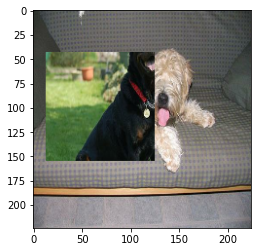

In [15]:
mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
plt.imshow(mixed_img.numpy())

## 라벨 섞기
---

In [16]:
# mix two labels
def mix_2_label(label_a, label_b, xa, ya, xb, yb, img_size=224, num_classes=120):
    mixed_area = (xb-xa)*(yb-ya)
    total_area = img_size*img_size
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

In [17]:
mixed_label = mix_2_label(label_a, label_b, xa, ya, xb, yb)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.75, 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
      dtype=float32)>

## ```cutmix()``` 함수 구현
- 위에서 구현한 두 함수, ```mix_2_images()```, ```mix_2_label()```를 활용해서 배치단위의 함수 선언

In [18]:
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

## ```apply_normalize_on_dataset()```
---


In [19]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_crop(image, [224, 224, 3])
    image = tf.image.random_hue(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.2, upper=0.5)
    return image,label

def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
#     label = tf.reshape(tf.stack(label),(batch_size, num_classes))
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    
    ds = ds.batch(batch_size)
    
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
        
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

In [20]:
num_classes = ds_info.features["label"].num_classes

In [21]:
apply_normalize_on_dataset(ds_train, batch_size=16, with_aug=False, with_cutmix=True)

<PrefetchDataset shapes: ((16, 224, 224, 3), (16, 120)), types: (tf.float32, tf.float32)>

# 모델 생성 및 훈련
---
- 비교를 위해서 두 가지 모델을 만든다.
    1. ResNet50 with normal data
    2. ResNet50 with augmented data
    3. ResNet50 with cutmix data

## 데이터 준비
---
1. ds_train_normal
2. ds_train_aug
3. ds_train_cutmix
4, ds_test

### 하이퍼파라미터

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

lr = 0.005
batch_size = 16

es_3 = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
es_5 = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
es = es_5

steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size)
validation_steps=int(ds_info.splits['test'].num_examples/batch_size)
epochs=25

In [23]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

In [24]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train_normal = apply_normalize_on_dataset(
    ds_train,
    batch_size=batch_size,
    with_aug=False,
    with_cutmix=False,
)
ds_train_aug = apply_normalize_on_dataset(
    ds_train,
    batch_size=batch_size,
    with_aug=True,
    with_cutmix=False,
)
ds_train_cutmix = apply_normalize_on_dataset(
    ds_train,
    batch_size=batch_size,
    with_aug=False,
    with_cutmix=True,
)
ds_train_all = apply_normalize_on_dataset(
    ds_train,
    batch_size=batch_size,
    with_aug=True,
    with_cutmix=True
)

ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

## 모델
---
- 총 4가지 학습을 시도
    1. ```resnet50``` : Augmentation X, CutMix X
    2. ```resnet50_aug``` : Augmentation O, CutMix X
    3. ```resnet50_cutmix``` : Augmentation X, CutMix O
    4. ```renset50_all``` : Augmentation O, CutMix O

### 모델 생성 및 학습
---
- Learning rate : 0.005
- callback : EarlyStopping, patience=5


In [25]:
tf.random.set_seed(1994)

#### ResNet50, Normal Data

In [26]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [27]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=lr),
    metrics=['accuracy'],
)

history_resnet50_normal = resnet50.fit(
    ds_train_normal, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=epochs,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[es]
)

Epoch 1/25
750/750 [==============================] - 109s 145ms/step - loss: 2.7301 - accuracy: 0.3749 - val_loss: 3.5176 - val_accuracy: 0.1804
Epoch 2/25
750/750 [==============================] - 109s 146ms/step - loss: 1.0421 - accuracy: 0.7212 - val_loss: 1.1055 - val_accuracy: 0.6737
Epoch 3/25
750/750 [==============================] - 112s 149ms/step - loss: 0.5386 - accuracy: 0.8714 - val_loss: 1.0816 - val_accuracy: 0.6890
Epoch 4/25
750/750 [==============================] - 110s 146ms/step - loss: 0.2592 - accuracy: 0.9552 - val_loss: 0.9394 - val_accuracy: 0.7225
Epoch 5/25
750/750 [==============================] - 110s 146ms/step - loss: 0.1450 - accuracy: 0.9841 - val_loss: 0.9630 - val_accuracy: 0.7215
Epoch 6/25
750/750 [==============================] - 111s 147ms/step - loss: 0.0872 - accuracy: 0.9932 - val_loss: 0.9424 - val_accuracy: 0.7327
Epoch 7/25
750/750 [==============================] - 110s 147ms/step - loss: 0.0594 - accuracy: 0.9966 - val_loss: 0.9515 -

In [28]:
del resnet50

#### ResNet50, Augmented data

In [29]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [30]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=lr),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
   ds_train_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=epochs,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[es]
)

Epoch 1/25
750/750 [==============================] - 113s 151ms/step - loss: 2.9724 - accuracy: 0.3164 - val_loss: 1.9484 - val_accuracy: 0.4810
Epoch 2/25
750/750 [==============================] - 112s 150ms/step - loss: 1.3640 - accuracy: 0.6221 - val_loss: 1.7755 - val_accuracy: 0.5146
Epoch 3/25
750/750 [==============================] - 112s 149ms/step - loss: 0.9390 - accuracy: 0.7352 - val_loss: 1.2655 - val_accuracy: 0.6375
Epoch 4/25
750/750 [==============================] - 111s 148ms/step - loss: 0.6828 - accuracy: 0.8129 - val_loss: 1.4021 - val_accuracy: 0.6019
Epoch 5/25
750/750 [==============================] - 110s 147ms/step - loss: 0.4681 - accuracy: 0.8784 - val_loss: 1.1679 - val_accuracy: 0.6604
Epoch 6/25
750/750 [==============================] - 110s 147ms/step - loss: 0.3338 - accuracy: 0.9196 - val_loss: 1.2354 - val_accuracy: 0.6523
Epoch 7/25
750/750 [==============================] - 110s 147ms/step - loss: 0.2124 - accuracy: 0.9586 - val_loss: 1.1287 -

In [31]:
del aug_resnet50

#### ResNet50, CutMix data

In [32]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [33]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=lr),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=epochs,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[es]
)

Epoch 1/25
  2/750 [..............................] - ETA: 52s - loss: 4.9996 - accuracy: 0.0938WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0496s vs `on_train_batch_end` time: 0.0916s). Check your callbacks.


750/750 [==============================] - 113s 151ms/step - loss: 4.1317 - accuracy: 0.1591 - val_loss: 3.5537 - val_accuracy: 0.1785
Epoch 2/25
750/750 [==============================] - 112s 150ms/step - loss: 3.1426 - accuracy: 0.3838 - val_loss: 1.4496 - val_accuracy: 0.5974
Epoch 3/25
750/750 [==============================] - 113s 150ms/step - loss: 2.8242 - accuracy: 0.4767 - val_loss: 1.1673 - val_accuracy: 0.6770
Epoch 4/25
750/750 [==============================] - 112s 150ms/step - loss: 2.6306 - accuracy: 0.5322 - val_loss: 1.2185 - val_accuracy: 0.6644
Epoch 5/25
750/750 [==============================] - 112s 150ms/step - loss: 2.4738 - accuracy: 0.5888 - val_loss: 1.2364 - val_accuracy: 0.6625
Epoch 6/25
750/750 [==============================] - 112s 150ms/step - loss: 2.3741 - accuracy: 0.6204 - val_loss: 1.1254 - val_accuracy: 0.6940
Epoch 7/25
750/750 [==============================] - 112s 150ms/step - loss: 2.2681 - accuracy: 0.6504 - val_loss: 1.0099 - val_accura

In [34]:
del cutmix_resnet50

#### ResNet50, Augmented + CutMix data

In [35]:
all_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [36]:
all_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=lr),
    metrics=['accuracy'],
)

history_resnet50_all = all_resnet50.fit(
    ds_train_all, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=epochs,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[es]
)

Epoch 1/25
  2/750 [..............................] - ETA: 46s - loss: 5.3344 - accuracy: 0.0312WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0456s vs `on_train_batch_end` time: 0.0792s). Check your callbacks.


750/750 [==============================] - 113s 151ms/step - loss: 4.3528 - accuracy: 0.1052 - val_loss: 2.6808 - val_accuracy: 0.3113
Epoch 2/25
750/750 [==============================] - 112s 150ms/step - loss: 3.3989 - accuracy: 0.3121 - val_loss: 1.9706 - val_accuracy: 0.4740
Epoch 3/25
750/750 [==============================] - 112s 150ms/step - loss: 3.0813 - accuracy: 0.3979 - val_loss: 1.6410 - val_accuracy: 0.5504
Epoch 4/25
750/750 [==============================] - 112s 150ms/step - loss: 2.8751 - accuracy: 0.4602 - val_loss: 1.5510 - val_accuracy: 0.5770
Epoch 5/25
750/750 [==============================] - 113s 150ms/step - loss: 2.7453 - accuracy: 0.4979 - val_loss: 1.4535 - val_accuracy: 0.5982
Epoch 6/25
750/750 [==============================] - 113s 150ms/step - loss: 2.6361 - accuracy: 0.5318 - val_loss: 1.2020 - val_accuracy: 0.6602
Epoch 7/25
750/750 [==============================] - 113s 150ms/step - loss: 2.5450 - accuracy: 0.5623 - val_loss: 1.2108 - val_accura

In [37]:
del all_resnet50

## 2-3) 결과 비교

### 그래프 시각화

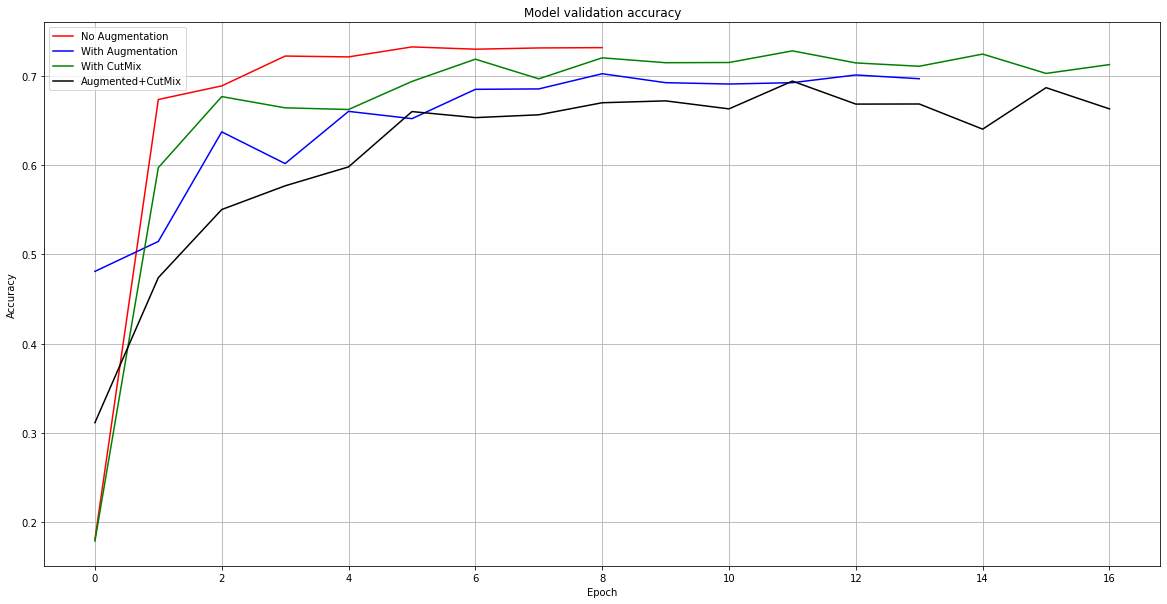

In [38]:
plt.figure(figsize=(20, 10))
plt.plot(history_resnet50_normal.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_all.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'Augmented+CutMix'], loc='best')
plt.grid(True)
plt.savefig('fig1_Accuracy.png')
plt.show()

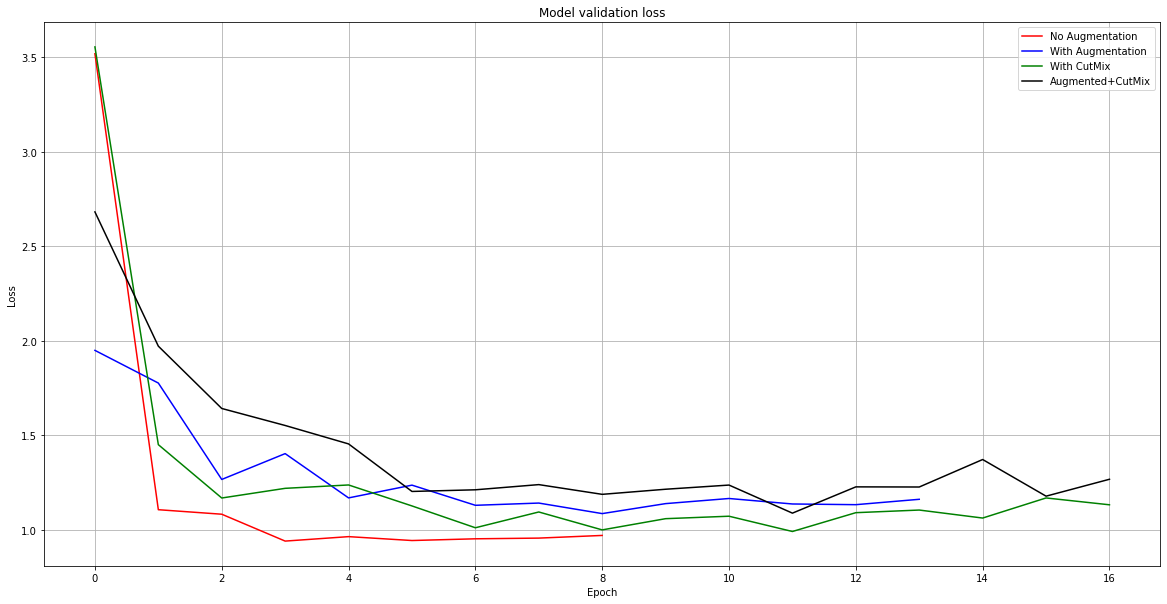

In [39]:
plt.figure(figsize=(20,10))
plt.plot(history_resnet50_normal.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'g')
plt.plot(history_resnet50_all.history['val_loss'], 'k')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'Augmented+CutMix'], loc='best')
plt.grid(True)
plt.savefig('fig1_loss.png')
plt.show()

In [40]:
print(f"Augmentation X, CutMix X Data's best accuracy : {round(max(history_resnet50_normal.history['val_accuracy']), 3)}")
print(f"Augmentation O, CutMix X Data's best accuracy : {round(max(history_resnet50_aug.history['val_accuracy']), 3)}")
print(f"Augmentation X, CutMix O Data's best accuracy : {round(max(history_resnet50_cutmix.history['val_accuracy']), 3)}")
print(f"Augmentation O, CutMix O Data's best accuracy : {round(max(history_resnet50_all.history['val_accuracy']), 3)}")

Augmentation X, CutMix X Data's best accuracy : 0.733
Augmentation O, CutMix X Data's best accuracy : 0.703
Augmentation X, CutMix O Data's best accuracy : 0.728
Augmentation O, CutMix O Data's best accuracy : 0.694


### 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

#### 평가문항/상세기준

1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?  
CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.


2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?  
Augmentation 적용을 통해 Augmentaion 미적용시 대비 5% 이상의 성능향상을 확인함


3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?  
기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.

## 회고 및 고찰

- 메모리 때문에 모델들은 학습을 마치고 ```del```을 사용해서 삭제시켜주고 새로운 모델을 다시 만들어서 문제를 해결하였다.

 - Accuracy 결과
       
        Augmentation X, CutMix X Data's best accuracy : 0.729
        Augmentation O, CutMix X Data's best accuracy : 0.743
        Augmentation X, CutMix O Data's best accuracy : 0.726
        Augmentation O, CutMix O Data's best accuracy : 0.736       
   
일반 데이터나 CutMix한 데이터나 Augmentation을 수행했을 때, Accuracy는 올라가는 것을 확인 할 수 있었다. 

실제 과제에서 Augmentation 기법을 사용할 수 있을지는 아직 감이 오지 않지만 새로운 것을 알 수 있는 것에 만족할 수 있었다. 

